In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from darts import TimeSeries
from darts.models import TFTModel
import torch
freq='2H3T14S'

In [3]:
def load_dataset(training_file, testing_file):
    dataframes = []
    for data_file in [training_file, testing_file]:
        parser = lambda data_string: datetime.strptime(data_string, '%Y-%m-%d %H:%M:%S')
#         dataframe = pd.read_csv(data_file)
        dataframe = pd.read_csv(data_file, parse_dates=['Time'],
                                date_parser=parser)
        print(f"Rows in {data_file}: {len(dataframe)}")
        dataframe.drop(['Ls', 'LT', 'CO2ice'], axis=1, inplace=True)
#         dataframe.index.name = "Time"

        # if data_file == training_file:
        #     dataframe[TRAINING_FLAG_COLUMN] = True
        # elif data_file == testing_file:
        #     dataframe[TRAINING_FLAG_COLUMN] = False

        dataframes.append(dataframe)

    return pd.concat(dataframes, axis=0)

In [4]:
dataframe = load_dataset('../data/data_files/insight_openmars_training_time.csv',
                         '../data/data_files/insight_openmars_test_time.csv')
dataframe.head()

/tmp/ipykernel_37943/1492825542.py:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  dataframe = pd.read_csv(data_file, parse_dates=['Time'],


Rows in ../data/data_files/insight_openmars_training_time.csv: 72196
Rows in ../data/data_files/insight_openmars_test_time.csv: 16364


/tmp/ipykernel_37943/1492825542.py:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  dataframe = pd.read_csv(data_file, parse_dates=['Time'],


,Time,Tsurf,Psurf,cloud,vapour,u_wind,v_wind,dust,temp
0,1998-07-15 21:23:39,264.042,721.113,0.092,0.027,-7.451,8.604,0.428,179.686
1,1998-07-15 23:26:53,274.736,705.090,0.145,0.026,-7.053,4.934,0.427,174.502
2,1998-07-16 01:30:07,265.939,700.691,0.105,0.026,-6.825,-0.063,0.427,173.429
3,1998-07-16 03:33:21,238.624,697.252,0.134,0.025,-5.373,-4.048,0.426,173.556
4,1998-07-16 05:36:35,213.634,717.146,0.139,0.026,-3.899,-3.133,0.426,174.789


In [5]:
# df_time_indexed = dataframe.set_index('Time')
time = pd.date_range("1998-07-15 21:23:39", periods=len(dataframe), freq=freq)
dataframe.index = time
dataframe = dataframe.drop(['Time'], axis=1)
dataframe.head()

,Tsurf,Psurf,cloud,vapour,u_wind,v_wind,dust,temp
1998-07-15 21:23:39,264.042,721.113,0.092,0.027,-7.451,8.604,0.428,179.686
1998-07-15 23:26:53,274.736,705.090,0.145,0.026,-7.053,4.934,0.427,174.502
1998-07-16 01:30:07,265.939,700.691,0.105,0.026,-6.825,-0.063,0.427,173.429
1998-07-16 03:33:21,238.624,697.252,0.134,0.025,-5.373,-4.048,0.426,173.556
1998-07-16 05:36:35,213.634,717.146,0.139,0.026,-3.899,-3.133,0.426,174.789


<Axes: xlabel='time'>

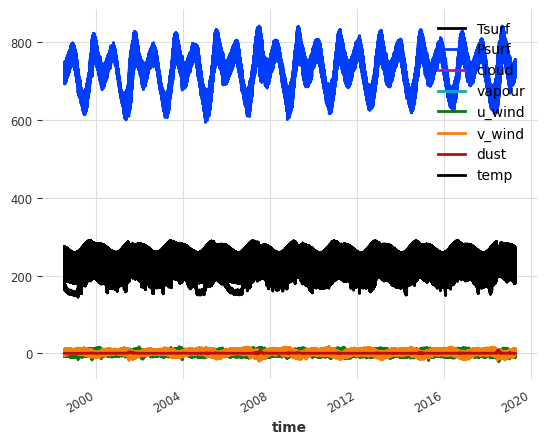

In [6]:
series = TimeSeries.from_dataframe(dataframe, time_col=None, value_cols=None, fill_missing_dates=True, freq='7394S', fillna_value=None)
series.plot()

<Axes: xlabel='time'>

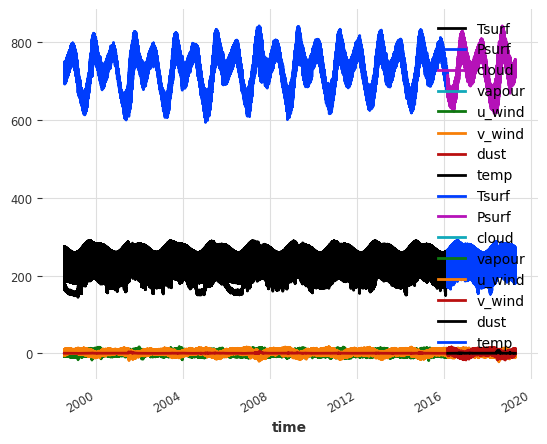

In [7]:
train_series, val_series = series.split_before(0.85)
train_series.plot()
val_series.plot()

In [17]:

from darts.metrics import rmse

# We first set aside the first 80% as training series:

def eval_model(model, series, past_covariates=None, future_covariates=None):
    # Past and future covariates are optional because they won't always be used in our tests
    
    # We backtest the model on the last 20% of the flow series, with a horizon of 10 steps:
    backtest = model.historical_forecasts(series=series, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          retrain=False,
                                          verbose=True, 
                                          forecast_horizon=12)
    
    series['dust'].plot()
    backtest.plot(label='backtest (n=12)')
    print('Backtest RMSE = {}'.format(rmse(series, backtest)))
    return backtest

SyntaxError: invalid syntax (3140901406.py, line 16)

In [14]:

from darts.models import BlockRNNModel

brnn_no_cov = BlockRNNModel(input_chunk_length=24, 
                            output_chunk_length=12, 
                            n_rnn_layers=2)

brnn_no_cov.fit(train_series['dust'], 
                epochs=1, 
                verbose=True)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | fc            | Sequential       | 312   
---------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


BlockRNNModel(model=RNN, hidden_dim=25, n_rnn_layers=2, hidden_fc_sizes=None, dropout=0.0, input_chunk_length=24, output_chunk_length=12)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Backtest RMSE = 0.13317692054241712


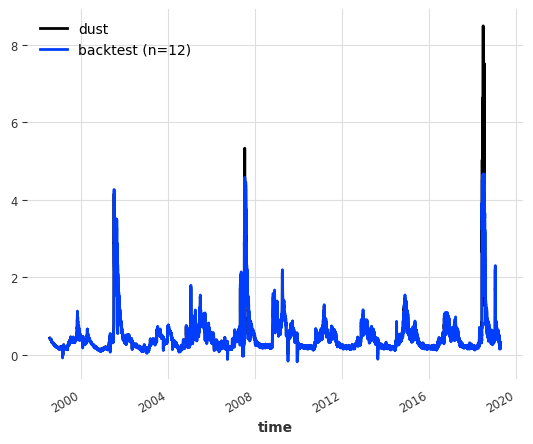

In [18]:
eval_model(brnn_no_cov, series['dust'])

<Axes: xlabel='time'>

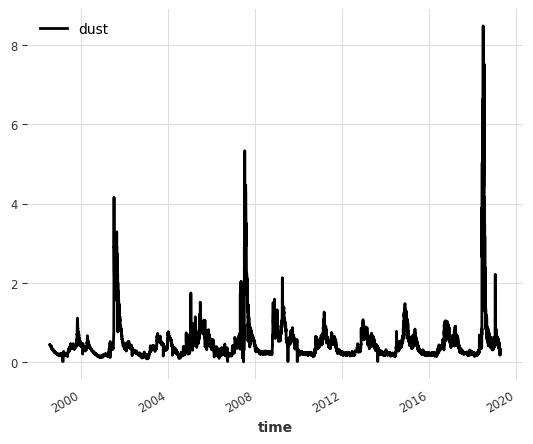

In [19]:
series['dust'].plot()